In [1]:
import requests 
import pandas as pd
def get_USGS_data(file_format='json', sites='09380000', start_date='2010-10-01', end_date='2023-10-01', site_status='all'):
    server = 'https://waterservices.usgs.gov'
    endpoint = '/nwis/dv'
    file_format = f'/?format={file_format}'
    sites = f'&sites={sites}'
    start_date = f'&startDT={start_date}'
    end_date = f'&endDT={end_date}'
    site_status = f'&siteStatus={site_status}'
    
    url = f'{server}{endpoint}{file_format}{sites}{start_date}{end_date}{site_status}'
    print(url)
    req = requests.get(url)
        #Correct url for reference:
        #'https://waterservices.usgs.gov/nwis/dv/?format=json&sites=09380000&startDT=1921-10-01&endDT=2023-10-01&siteStatus=all'
    
    if req.ok:
        df = pd.DataFrame.from_dict(pd.DataFrame(req.json()['value']['timeSeries'][0]['values'][0]['value']))
        # df.set_index('dateTime', inplace=True)
        return req, df
        

In [30]:
req, df = get_USGS_data(sites='09380000', start_date='1921-10-01', end_date='2023-10-01')

https://waterservices.usgs.gov/nwis/dv/?format=json&sites=09380000&startDT=1921-10-01&endDT=2023-10-01&siteStatus=all


In [54]:
df.to_csv("leesferry_webservice.csv")

In [31]:
df.head(1)

,value,qualifiers,dateTime
0,12.0,[A],1986-10-17T00:00:00.000


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import calendar
# from scipy.integrate import trapz
from collections import OrderedDict

class StackedLinePlot:
    def __init__(self, csv_path, name_of_date_column, name_of_Q_column):
        self.csv_path = csv_path
        self._name_of_date_column = name_of_date_column
        self._name_of_Q_column = name_of_Q_column
        self.df = csv_path
        self._df = self.df
        self._df_stat_summary = self._df.describe()
        self._df['Date'] = pd.to_datetime(self._df[name_of_date_column])
        self._df = self._df[~self._df.duplicated('Date')]
        self._df['month'] = self._df['Date'].dt.month
        self._df['Year'] = self._df['Date'].dt.year
        self._df['month-day'] = self._df['Date'].apply(lambda x: x.strftime('%m-%d'))
        self._df['Water Year'] = self._df['Date'].dt.year.where(self._df['Date'].dt.month<10, self._df['Date'].dt.year+1)
        # self._pivot_table = self._df.pivot(index="month-day", columns='Year', values=name_of_Q_column)
        # self._pivot_table_monthly = self._df.pivot(columns='month', values=name_of_Q_column)
        # self._pivot_table_yearly_stats = {year: self._pivot_table.iloc[:, i].describe() for i, year in enumerate(self._pivot_table.columns)}
        self._forced_x_positions = None
        self._forced_x_labels = None
        self._mean = None
        self._median = None
        self._st_dev = None
        self._lower_bound = None
        self._upper_bound = None
        self._lower_bound_percentile25 = None
        self._upper_bound_percentile75 = None
        self._colors = ['crimson', 'springgreen', 'dodgerblue', 'purple', 'green', 'deeppink', "lawngreen", "coral", "lime", "navy", "goldenrod"]
        # self._ylim_max = self.df[name_of_Q_column].max() + self.df[name_of_Q_column].max() * 0.05
        # print(self._ylim_max)
    @property
    def df(self):
        return self._df

    @df.setter
    def df(self, csv_path):
        if isinstance(csv_path, pd.DataFrame):
            print("Data is in the form of a DataFrame.")
            self._df = csv_path.copy()  # Set the DataFrame directly

        elif isinstance(csv_path, str):
            try:
                print(f"Importing CSV with the file path: {csv_path}")
                self._df = pd.read_csv(csv_path)
                # Convert columns to numeric, handling errors by setting non-numeric values to NaN
                self._df[self._name_of_Q_column] = pd.to_numeric(self._df[self._name_of_Q_column], errors='coerce')
                # self._df['Year'] = pd.to_numeric(self._df['Year'], errors='coerce')
            except Exception as e:
                print(f"Error reading CSV file: {e}")
                return
        else:
            print("Invalid input type. Please provide either a pandas DataFrame or a CSV file path.")
            return



    def calculate_statistics(self):
        # print(self._df)
        # self._df2 = self._df[["month-day", "value"]]
        # print(self._df2)
        self._stats = self._df.groupby("month-day")[self._name_of_Q_column].agg(['mean', 'median', 'std', ("q25", lambda x: x.quantile(0.25)), ("q75", lambda y: y.quantile(0.75))])
        self._monthly_stats = self._df.groupby("month")[self._name_of_Q_column].agg(['mean', 'median', 'std', ("q25", lambda x: x.quantile(0.25)), ("q75", lambda y: y.quantile(0.75))])
        self._mean = self._stats.iloc[:, 0]
        self._median = self._stats.iloc[:, 1]
        self._st_dev = self._stats.iloc[:, 2]
        self._percentile25 = self._stats.iloc[:, 3]
        self._percentile75 = self._stats.iloc[:, 4]
        self._lower_bound_st_dev = self._mean - self._st_dev
        self._upper_bound_st_dev = self._mean + self._st_dev
        self._lower_bound_percentile25 = self._mean - self._percentile25
        self._upper_bound_percentile75 = self._mean + self._percentile75

    # def calculate_yearly_volumes(self):
    #     years = []
    #     area = []
    #     for year in self._pivot_table.columns:
    #         dates = list(range(0, len(self._pivot_table[year].dropna())))
    #         area.append(trapz(self._pivot_table[year].dropna(), dates))
    #         years.append(year)

    #     Area_dict = OrderedDict()
    #     for key, value in zip(years, area):
    #         Area_dict[key] = value
        # return Area_dict


    
    def plotStackedLinePlot(self, **kwargs):
       
        self._prepare_data_for_plotting(kwargs.get('input_start_year', 2010), kwargs.get('input_end_year', 2020))

        fig, ax = plt.subplots(figsize=(9, 7))

        self._plot_central_tendency_stats(ax, kwargs.get('plot_central_tendency_stats', True))
        self._plot_highlighted_years(ax, kwargs.get('highlight_years', []))
        self._plot_quartile_shading(ax, kwargs.get('quartile_shading', True), kwargs.get('quartile_shading_alpha', 0.5), kwargs)

        if kwargs.get('group_by_decade', False):
            self._plot_grouped_by_decade(ax, kwargs)
        else:
            self._plot_individual_years(ax, kwargs.get('series_alpha', 0.3), kwargs)

        self._customize_plot(ax, kwargs)
        plt.show()


    def _prepare_data_for_plotting(self, start_year, end_year, **kwargs):
        water_year = kwargs.get('water_year', True)
        if water_year:
            year = 'Water Year'
        else:
            year = 'Year'
            
        self._df = self._df[(self._df[year] >= start_year) & (self._df[year] <= end_year)]
        self._unique_years = self._df[year].unique()
        self._start_year, self._end_year = self._unique_years[0], self._unique_years[-1]
        self._num_of_decades = math.ceil((self._end_year - self._start_year) / 10)
        self._unique_decades = self._df[year].apply(lambda year: (year // 10) * 10).unique()

        # Convert years in _pivot_table to water years
        water_year_col = self._df['Water Year'].unique()
        self._pivot_table = self._df.copy()
        self._pivot_table['month-day'] = self._pivot_table['Date'].apply(lambda x: x.strftime('%m-%d'))
        self._pivot_table = self._pivot_table.pivot(index="month-day", columns=year, values=self._name_of_Q_column)
        self._pivot_table = self._pivot_table[water_year_col]
        self._pivot_table_monthly = self._df.pivot(columns='month', values=self._name_of_Q_column)
        self._pivot_table_yearly_stats = {year: self._pivot_table.iloc[:, i].describe() for i, year in enumerate(self._pivot_table.columns)}

        
        # self._pivot_table = self._df.pivot(index="month-day", columns=year, values=self._name_of_Q_column)
        # self._pivot_table = self._pivot_table[water_year_col]
        # self._pivot_table_monthly = self._df.pivot(columns='month', values=self._name_of_Q_column)
        # self._pivot_table_yearly_stats = {year: self._pivot_table.iloc[:, i].describe() for i, year in enumerate(self._pivot_table.columns)}

        self.calculate_statistics()


    def _plot_central_tendency_stats(self, ax, plot_stats):
        if plot_stats:
            self._mean.plot(ax=ax, label="Mean", linestyle=':', color='black', linewidth=1.5, zorder=3)
            self._median.plot(ax=ax, label="Median", linestyle=':', color='red', linewidth=1.5, zorder=3)

    def _plot_highlighted_years(self, ax, highlight_years):
        for i, year in enumerate(highlight_years):
            # if water_year:
            #     year = 'Water Year'
            # else:
            #     year = 'Year'
            
            self._pivot_table[year].plot(ax=ax, linewidth=1.6, zorder=3, color=self._colors[i])
            

    def _plot_quartile_shading(self, ax, quartile_shading, quartile_shading_alpha, kwargs):
        if quartile_shading:
            zorder = kwargs.get('quartile_shading_zorder', 1)
    
            plt.fill_between(
                list(range(0, len(pd.DataFrame(self._mean).iloc[:, 0]))),
                pd.DataFrame(self._mean).iloc[:, 0].astype(float),
                pd.DataFrame(self._lower_bound_st_dev).iloc[:, 0].astype(float),
                where=(pd.DataFrame(self._mean).iloc[:, 0].astype(float) > pd.DataFrame(self._lower_bound_percentile25).iloc[:, 0].astype(float)),
                interpolate=True, color='yellow', alpha=quartile_shading_alpha, zorder=zorder, label="q25-q75")
    
            plt.fill_between(
                list(range(0, len(pd.DataFrame(self._mean).iloc[:, 0]))),
                pd.DataFrame(self._mean).iloc[:, 0].astype(float),
                pd.DataFrame(self._upper_bound_st_dev).iloc[:, 0].astype(float),
                where=(pd.DataFrame(self._mean).iloc[:, 0].astype(float) < pd.DataFrame(self._upper_bound_percentile75).iloc[:, 0].astype(float)),
                interpolate=True, color='yellow', alpha=quartile_shading_alpha, zorder=zorder)

        
    def _plot_grouped_by_decade(self, ax, kwargs):
        for i, decade in enumerate(self._unique_decades):
            years_in_decade = [year for year in self._unique_years if decade <= year < decade + 10]
            mean_values = self._pivot_table[years_in_decade].mean(axis=1)
            std_dev_values = self._pivot_table[years_in_decade].std(axis=1)
            ax.plot(self._pivot_table.index, mean_values, label=f'Decade {decade}s', color=self._colors[i])
            ax.fill_between(self._pivot_table.index, mean_values - std_dev_values, mean_values + std_dev_values, alpha=0.2, color=self._colors[i])

    def _plot_individual_years(self, ax, series_alpha, kwargs):
        for i, year in enumerate(self._unique_years):
            ax.plot(self._pivot_table.index, self._pivot_table[year], label=f'{year}', alpha=series_alpha)

    def _customize_plot(self, ax, kwargs):
        self._forced_x_positions = kwargs.get('forced_x_positions', [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 336]),
        self._forced_x_labels = kwargs.get('forced_x_labels', ['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01'])

        if self._forced_x_positions is not None and self._forced_x_labels is not None:
            print(self._forced_x_positions[0])
            print(self._forced_x_labels)
            ax.set_xticks(self._forced_x_positions[0])
            ax.set_xticklabels(self._forced_x_labels, rotation=45)
            xlim_min = self._forced_x_positions[0][0]
            xlim_max = self._forced_x_positions[0][-1]
            ax.set_xlim([xlim_min, xlim_max])
            ax.set_ylim([kwargs.get('y_lower_lim', 0), kwargs.get('y_upper_lim', 25)])
            

        plt.grid(color='green', linestyle=":", linewidth=0.5)
        plt.xlabel('Month-Day')
        plt.ylabel(kwargs.get('ylabel', "Discharge (cfs)"))
        plt.title(kwargs.get('title'))

        
        if kwargs.get('legend_mode') == "partial":
            labels = ['Mean', 'Median'] + kwargs.get('highlight_years', [])
            plt.legend(loc=kwargs.get('legend_pos', ' upper right'), ncol=kwargs.get('legend_ncol', 1), labels=['Mean', 'Median'] + kwargs.get('highlight_years', []))
        else:
            plt.legend(loc=kwargs.get('legend_pos'), ncol=kwargs.get('legend_ncol'))#, labels=labels)
        
if __name__ == "__main__":
    print("-------This module creates customized StackedLinePlots.-------")




-------This module creates customized StackedLinePlots.-------


In [158]:
# LeesFerry2._df

In [159]:
# LeesFerry2._pivot_table

Importing CSV with the file path: leesferry_webservice.csv
[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 336]
['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01']


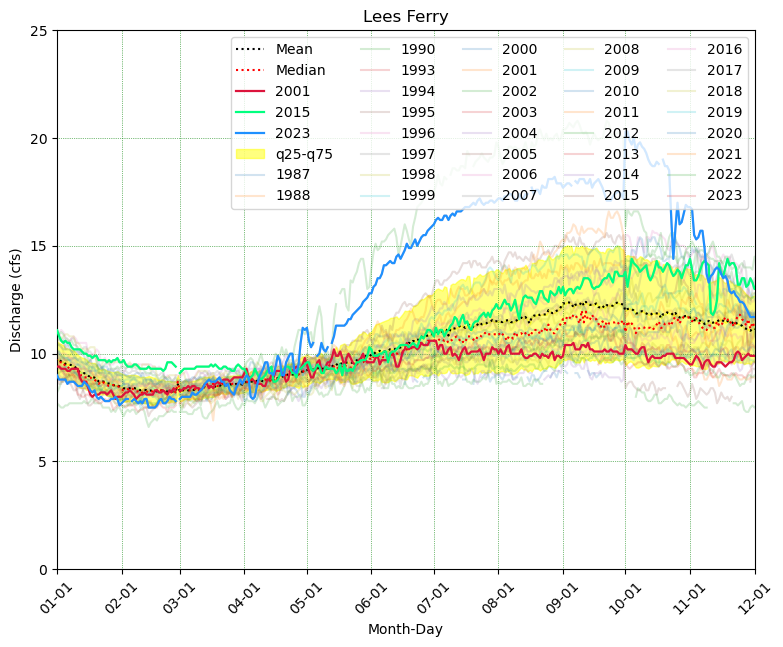

In [2]:
LeesFerry2 = StackedLinePlot(csv_path="leesferry_webservice.csv", name_of_date_column='dateTime', name_of_Q_column='value')
# LeesFerry2 = StackedLinePlot(csv_path=df, name_of_date_column='dateTime', name_of_Q_column='value')
LeesFerry2.calculate_statistics()
LeesFerry2.plotStackedLinePlot(
    # forced_x_positions=[274, 305, 336, 1, 32, 60, 91, 121, 152, 182, 213, 244],  
    # forced_x_labels=['10-01', '11-01', '12-01', '01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01'],  # Added comma here
    title="Lees Ferry",
    highlight_years=[2001, 2015, 2023],
    plot_central_tendency_stats=True,
    quartile_shading=True,
    quartile_shading_alpha=.5,
    quartile_shading_zorder=1,
    series_labels=True,
    series_alpha=.2,
    group_by_decade=False,
    decade_stats_to_plot="All",
    y_lower_lim=0,
    y_upper_lim=25,
    # legend_mode="partial",
    legend_pos='upper right',
    legend_ncol=5,
    input_start_year=1950,
    input_end_year=2023

)

In [29]:
LeesFerry2._

,value,qualifiers,dateTime,Date,month,Year,month-day,Water Year
0,12.0,[A],1986-10-17T00:00:00.000,1986-10-17,10,1986,10-17,1987
1,11.9,[A],1986-10-18T00:00:00.000,1986-10-18,10,1986,10-18,1987
2,11.5,[A],1986-10-19T00:00:00.000,1986-10-19,10,1986,10-19,1987
3,11.4,[A],1986-10-20T00:00:00.000,1986-10-20,10,1986,10-20,1987
4,11.5,[A],1986-10-21T00:00:00.000,1986-10-21,10,1986,10-21,1987
...,...,...,...,...,...,...,...,...
11002,17.5,[P],2023-09-27T00:00:00.000,2023-09-27,9,2023,09-27,2023
11003,17.5,[P],2023-09-28T00:00:00.000,2023-09-28,9,2023,09-28,2023
11004,17.4,[P],2023-09-29T00:00:00.000,2023-09-29,9,2023,09-29,2023
11005,17.2,[P],2023-09-30T00:00:00.000,2023-09-30,9,2023,09-30,2023
